In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from math import ceil
from scipy.stats import pointbiserialr

• Temperatura, medida em Celsius 
• duração das experiências, medida em minutos 
• velocidade do impulsor, medida em RPM 
• defletores, é uma variável categórica Sim ou Não 
• rendimento, é um rendimento percentual no final da experiência

In [2]:
df = pd.read_csv("biorreator.csv")
df

,temperature,duration,speed,baffles,yield
0,82,260,4300.0,No,51.0
1,90,260,3700.0,Yes,30.0
2,88,260,4200.0,Yes,40.0
3,86,260,3300.0,Yes,28.0
4,80,260,NaN,No,NaN
5,78,260,4300.0,Yes,49.0
6,82,260,3900.0,Yes,44.0
7,83,260,4300.0,No,59.0
8,64,260,4300.0,NaN,60.0
9,73,260,4400.0,No,59.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  14 non-null     int64  
 1   duration     14 non-null     int64  
 2   speed        13 non-null     float64
 3   baffles      13 non-null     object 
 4   yield        12 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 692.0+ bytes


<Axes: >

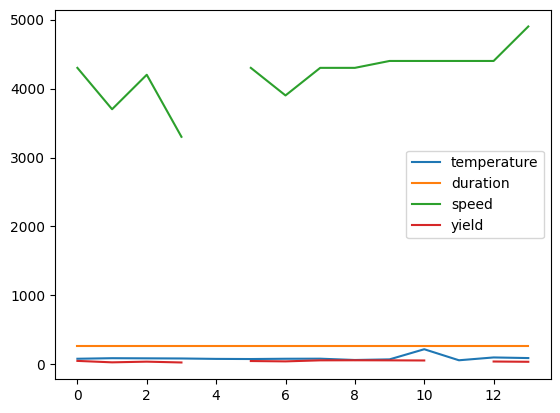

In [4]:
df.plot()

* Falta de dados (**speed**, **yield**, **baffles**)
* Escalas desporpocionais => Usar Standardization para colocar todos os dados à mesma escala (exceto variáveis categóricas)
* Variável categórica não plotada (**baffles**) => Pois ela é categórica, é necessário converter para um valor numérico
* Variável constante (**duration**) => Não serve para nada porque não varia

In [5]:
# Substituir NaN pela moda
df["baffles"].fillna(df["baffles"].mode()[0], inplace=True)

In [6]:
# Converter para binário
df["baffles"].replace(["Yes", "No"], [1, 0], inplace=True)

In [7]:
# Standardizar cada coluna, exceto baffles que é categórico
cols = set(df.columns) - {"baffles"}
for col in cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()
df

,temperature,duration,speed,baffles,yield
0,-0.242816,NaN,0.216269,0,0.408181
1,-0.035218,NaN,-1.317275,1,-1.462030
2,-0.087117,NaN,-0.039322,1,-0.571453
3,-0.139017,NaN,-2.339638,1,-1.640145
4,-0.294716,NaN,NaN,0,NaN
5,-0.346615,NaN,0.216269,1,0.230066
6,-0.242816,NaN,-0.806094,1,-0.215223
7,-0.216866,NaN,0.216269,0,1.120642
8,-0.709913,NaN,0.216269,0,1.209700
9,-0.476365,NaN,0.471860,0,1.120642


<Axes: >

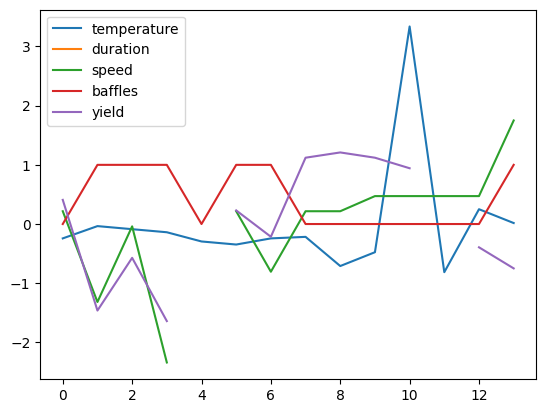

In [8]:
df.plot()


a) Remova atributos não informativos 

<Axes: >

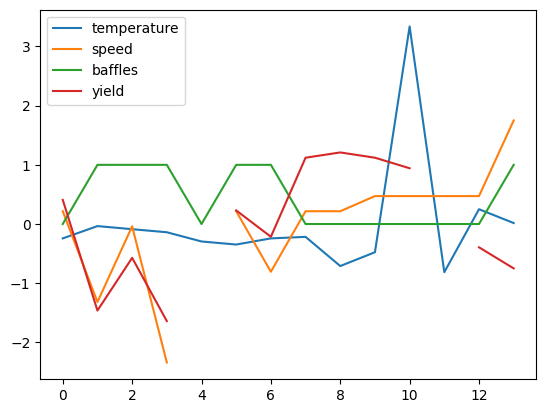

In [9]:
# Remover coluna constante
df.drop(columns=["duration"], inplace=True)
df.plot()

### Qual método de substituição escolher?
Vai se plotar apenas as variáveis com dados em falta

b) Remover os registos que contenham nulos

<Axes: >

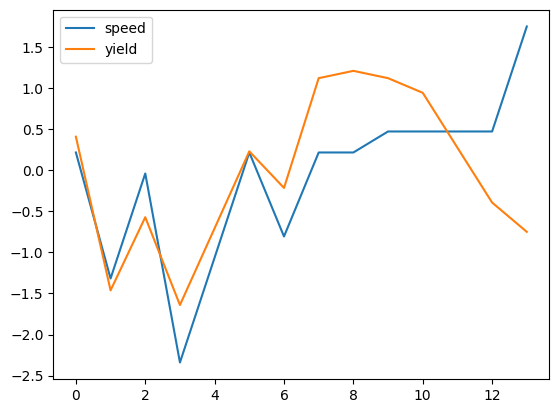

In [10]:
df_drop_rows = df.dropna(axis=0)
df_drop_rows[["speed", "yield"]].plot()

c) Remover os atributos que contenham nulos

Não haverá nada para plotar das variáveis com dados em falta! Com isto grande parte dos dados se perde, então não é uma boa alternativa.

In [11]:
df_drop_cols = df.dropna(axis=1)

#df_drop_cols[["speed", "yield"]].plot()

d) Preencher os valores nulos com os valores médios dos atributos 

Comparado com o método de remover  registos, nota-se que as curvas ficam mais "lisas", pois têm mais dados para mostrar.

<Axes: >

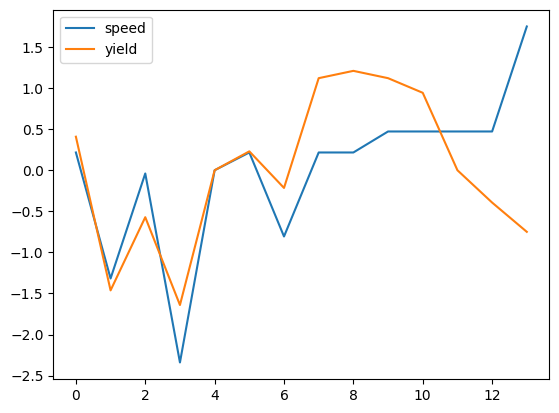

In [12]:
df_fillna_mean = df.copy()

cols = set(df_fillna_mean.columns) - {"baffles"}

for col in cols:
    df_fillna_mean[col].fillna(df_fillna_mean[col].mean(), inplace=True)

df_fillna_mean[["speed", "yield"]].plot()

In [13]:
df_fillna_mean

,temperature,speed,baffles,yield
0,-0.242816,2.162691e-01,0,4.081808e-01
1,-0.035218,-1.317275e+00,1,-1.462030e+00
2,-0.087117,-3.932165e-02,1,-5.714532e-01
3,-0.139017,-2.339638e+00,1,-1.640145e+00
4,-0.294716,3.928481e-16,0,2.312965e-16
5,-0.346615,2.162691e-01,1,2.300656e-01
6,-0.242816,-8.060939e-01,1,-2.152226e-01
7,-0.216866,2.162691e-01,0,1.120642e+00
8,-0.709913,2.162691e-01,0,1.209700e+00
9,-0.476365,4.718599e-01,0,1.120642e+00


e) Aplicar interpolação linear com os valores dos registos mais próximos. NOTA: Se os valores dos 
registos mais próximos forem nulos, deve procurar os primeiros valores não nulos do atributo e 
fazer uma média.

A interpolação linear, calcula a distância dos valores anteriores e garante que o valor nulo tem a mesma distância

Deve ser utilizado em variavéis cuja curva seja contínua.

In [14]:
df_fillna_linear_interpolation = df.copy()

df_fillna_linear_interpolation.interpolate(inplace=True)

<Axes: >

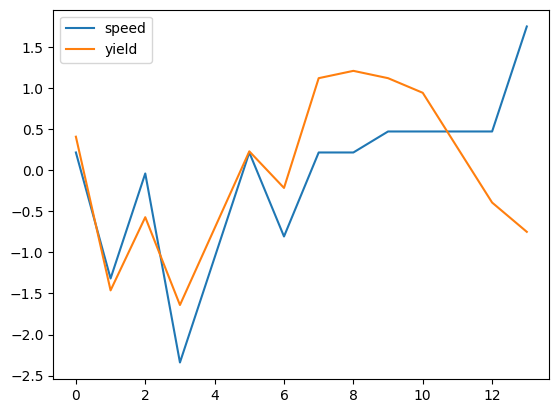

In [15]:
df_fillna_linear_interpolation[["speed", "yield"]].plot()

In [16]:
df_fillna_linear_interpolation

,temperature,speed,baffles,yield
0,-0.242816,0.216269,0,0.408181
1,-0.035218,-1.317275,1,-1.462030
2,-0.087117,-0.039322,1,-0.571453
3,-0.139017,-2.339638,1,-1.640145
4,-0.294716,-1.061685,0,-0.705040
5,-0.346615,0.216269,1,0.230066
6,-0.242816,-0.806094,1,-0.215223
7,-0.216866,0.216269,0,1.120642
8,-0.709913,0.216269,0,1.209700
9,-0.476365,0.471860,0,1.120642


Só se deve usar interpolação se houver continuidade nos valores.

**Vou utilizar a susbtituição por média, como método final**

In [17]:
cols = set(df.columns) - {"baffles"}

for col in cols:
    df[col].fillna(df[col].mean(), inplace=True)

df[col].fillna(df[col].mode()[0], inplace=True)

df

,temperature,speed,baffles,yield
0,-0.242816,2.162691e-01,0,4.081808e-01
1,-0.035218,-1.317275e+00,1,-1.462030e+00
2,-0.087117,-3.932165e-02,1,-5.714532e-01
3,-0.139017,-2.339638e+00,1,-1.640145e+00
4,-0.294716,3.928481e-16,0,2.312965e-16
5,-0.346615,2.162691e-01,1,2.300656e-01
6,-0.242816,-8.060939e-01,1,-2.152226e-01
7,-0.216866,2.162691e-01,0,1.120642e+00
8,-0.709913,2.162691e-01,0,1.209700e+00
9,-0.476365,4.718599e-01,0,1.120642e+00


2. Através de análise gráfica, verifique se existe alguma correlação linear assinalável entre cada um 
dos atributos preditores e a saída (yield)

Variáveis categóricas (**baffles**) serão removidas, pois não fazem sentido serem plotadas num gráfico de dispersão.

array([[<Axes: xlabel='temperature', ylabel='temperature'>,
        <Axes: xlabel='speed', ylabel='temperature'>,
        <Axes: xlabel='yield', ylabel='temperature'>],
       [<Axes: xlabel='temperature', ylabel='speed'>,
        <Axes: xlabel='speed', ylabel='speed'>,
        <Axes: xlabel='yield', ylabel='speed'>],
       [<Axes: xlabel='temperature', ylabel='yield'>,
        <Axes: xlabel='speed', ylabel='yield'>,
        <Axes: xlabel='yield', ylabel='yield'>]], dtype=object)

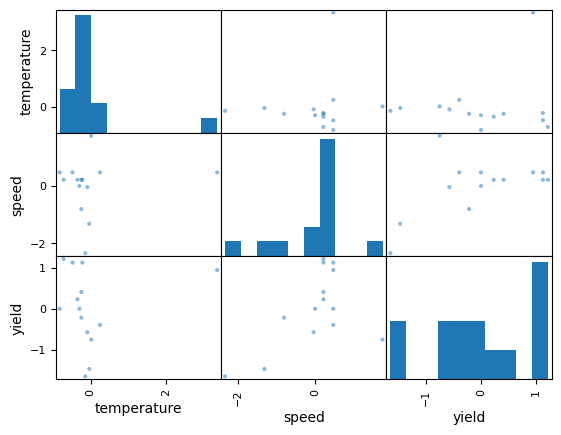

In [18]:
pd.plotting.scatter_matrix(df[["temperature", "speed", "yield"]])

É possível verificar uma leve correlação positiva entre `speed` e `yield`.

Entre `temperature` e `yield` a correlação deverá aproximar-se de 0, ou seja, sem correlação.

Para verificar `baffles` com `yield` usaremos um gráfico de violino

<Axes: xlabel='baffles', ylabel='yield'>

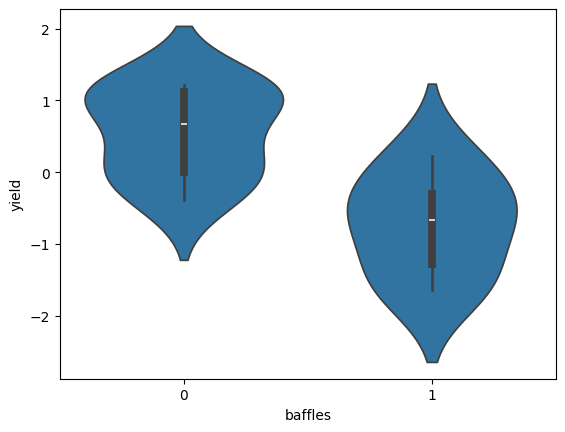

In [19]:
sns.violinplot(df[["baffles", "yield"]], x="baffles", y="yield")

Verifica-se que quando o `yield` é positivo o `baffles` é 0.
Já quando `baffles` tem o valor 1, os valores do `yield` amostram-se mais entre 0 e -1. Logo verifica-se uma proporcionalidade inversa, tendo assim uma correlação negativa

3. Verifique se existe dependência linear de linhas ou colunas, no dataset ‘biorreator.csv’. Que 
conclusão retira do resultado?

Usar-se-á correlação de pearson para todaas as variáveis numéricas, logo o **baffles** não estará presente. 

In [20]:
df[["temperature", "speed", "yield"]].corr()

,temperature,speed,yield
temperature,1.000000,0.108616,0.134008
speed,0.108616,1.000000,0.528982
yield,0.134008,0.528982,1.000000


Em relação a colunas a única depedência linear será entre `speed` e `yield`.

Agora vai-se comparar o baffles com as restantes das variáveis através de uma correlação ponto-bisserial.

Como pode-se observar a correlação entre `baffles` e `yield` é fortemente negativa e nota-se uma ligeira correlação negativa entre `baffles` e `speed`.

In [21]:
baffles = df["baffles"].to_numpy()
cols = set(df.columns) - {"baffles"}

data = dict()

for col in cols:
    data[col] = [pointbiserialr(df["baffles"].to_numpy(), df[col].to_numpy()).statistic, ]

df_data = pd.DataFrame(data, index=["baffles", ])

df_data

,yield,temperature,speed
baffles,-0.717833,-0.124937,-0.395407


4. Identifique os outliers, se existirem, de forma gráfica e de forma numérica.

As variáveis com outliers são `temperatures` e `speed`

<Axes: >

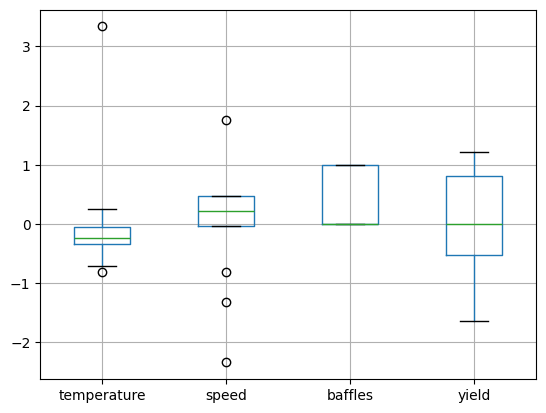

In [22]:
df.boxplot()

In [23]:
print("Mostra valores outliers\n")
for col in df.columns:
    print("##### " + col + " #####")
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    qi = q3 - q1
    for row in df[col]:
        if row < q1 - 1.5*qi or row > q3 + 1.5*qi:
            print(row)

Mostra valores outliers

##### temperature #####
3.338259088016144
-0.8137122374453568
##### speed #####
-1.3172754207869775
-2.3396384339350798
-0.8060939142129264
1.7498136186573292
##### baffles #####
##### yield #####


5. Altere a escala dos seguintes dados, para que variem entre 1 e 3. Arredonde a 2 casas decimais.

Usa-se a função min-max. Primeiramente transforma-se os valores para o intervalo [0,1]:

$x_{std} = \frac{x - x_{min}}{x_{max} - x_{min}}$, com $x_{min}$ e $x_{max}$ sendo o menor e maior valor, respetivamente, da coluna onde o $x$ está. 

Depois coloca-se na escala que se quer, neste caso, 1 e 3:

$x_{new} = x_{std} \cdot (3 - 1) + 1$


Pode-se usar o scikit-learn para fazer isto automaticamente:

```python
min_max = MinMaxScaler((1,3))
min_max.fit(df_data)
df_data[["A", "B", "C"]] = np.round( min_max.fit_transform(df_data[["A", "B", "C"]]), 2)
```

In [24]:
data = {'A': [10, 20, 30, 40, 50], 
 'B': [500, 1000, 200, 4000, 800], 
 'C': [5, 10, 5, 15, 20]}

In [25]:
df_data = pd.DataFrame(data)

minimum = 1 
maximum = 3

for col in df_data.columns:
    # Transformar para valores entre 0 e 1
    mi, ma = df_data[col].min(axis=0), df_data[col].max(axis=0)
    transform = lambda x, mi, ma: (x - mi) / (ma - mi)
    
    col_std = df_data[col].apply(lambda x: transform(x, mi, ma))

    # Colocar no intervalo que se quer
    df_data[col] = np.round( col_std.apply(lambda x: x * (maximum-minimum) + minimum), 2)

df_data

,A,B,C
0,1.0,1.16,1.00
1,1.5,1.42,1.67
2,2.0,1.00,1.00
3,2.5,3.00,2.33
4,3.0,1.32,3.00


6. Carregue o ficheiro ‘WA_Fn-UseC_-Sales-Win-Loss.csv’ para um dataframe. Faça uma amostragem 
dos dados que seja aleatória e representativa de toda a população do dataset. Considere um grau 
de confiança de 95%. NOTA: arredondar nº de amostras sempre para cima.

In [26]:
df = pd.read_csv("WA_Fn-UseC_-Sales-Win-Loss.csv")
df

,Opportunity Number,Supplies Subgroup,Supplies Group,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Competitor Type,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,Ratio Days Qualified To Total Days,Deal Size Category
0,1641984,Exterior Accessories,Car Accessories,Northwest,Fields Sales,76,Won,13,104,101,0,5,5,0,Unknown,0.69636,0.113985,0.154215,1
1,1658010,Exterior Accessories,Car Accessories,Pacific,Reseller,63,Loss,2,163,163,0,3,5,0,Unknown,0.00000,1.000000,0.000000,1
2,1674737,Motorcycle Parts,Performance & Non-auto,Pacific,Reseller,24,Won,7,82,82,7750,1,1,0,Unknown,1.00000,0.000000,0.000000,1
3,1675224,Shelters & RV,Performance & Non-auto,Midwest,Reseller,16,Loss,5,124,124,0,1,1,0,Known,1.00000,0.000000,0.000000,1
4,1689785,Exterior Accessories,Car Accessories,Pacific,Reseller,69,Loss,11,91,13,69756,1,1,0,Unknown,0.00000,0.141125,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78020,10089932,Batteries & Accessories,Car Accessories,Southeast,Reseller,0,Loss,2,0,0,250000,1,1,3,Unknown,0.00000,0.000000,0.000000,6
78021,10089961,Shelters & RV,Performance & Non-auto,Northeast,Reseller,0,Won,1,0,0,180000,1,1,0,Unknown,0.00000,0.000000,0.000000,5
78022,10090145,Exterior Accessories,Car Accessories,Southeast,Reseller,0,Loss,2,0,0,90000,1,1,0,Unknown,0.00000,0.000000,0.000000,4
78023,10090430,Exterior Accessories,Car Accessories,Southeast,Fields Sales,0,Loss,2,0,0,120000,1,1,0,Unknown,1.00000,0.000000,0.000000,5


A fórmula para calcular uma boa amostra é a seguinte:

$sample_{size} = \frac{\frac{z^2 \cdot \sigma \cdot (1-\sigma)}{e^2}}{1 + (\frac{z^2 \cdot \sigma \cdot (1-\sigma)}{e^2 \cdot N})}$

Com $z$ sendo o z-score do intervalo de confiança que se deseja (consultar tabela), $\sigma$ é o desvio-padrão que quando não se tem uma boa estimativa usa-se 0.5, $e$ é a margem de erro e $N$ é o tamanho da população

In [27]:
def sampling(z_score, std, error_margin, pop_size):
    return ((z_score**2 * std*(1-std))/error_margin**2) / (1 + ((z_score**2*std*(1-std))/(error_margin**2 * pop_size)))


In [28]:
# Amostragem com 95% de confiança (z_score = 1.96)
sample_size = sampling(1.96, 0.5, 0.02, len(df.index))
df.sample(ceil(sample_size))

,Opportunity Number,Supplies Subgroup,Supplies Group,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Competitor Type,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,Ratio Days Qualified To Total Days,Deal Size Category
8309,6708954,Motorcycle Parts,Performance & Non-auto,Pacific,Reseller,78,Loss,3,17,17,25000,1,1,0,Unknown,0.000000,0.656805,0.343195,3
16742,7166570,Batteries & Accessories,Car Accessories,Pacific,Fields Sales,27,Loss,5,51,51,170000,1,2,0,Known,0.103718,0.896282,0.000000,5
69039,8194999,Exterior Accessories,Car Accessories,Mid-Atlantic,Reseller,28,Loss,2,12,12,20000,1,1,0,Unknown,0.000000,1.000000,0.000000,2
53885,6910802,Garage & Car Care,Car Accessories,Southeast,Fields Sales,75,Loss,3,12,12,50000,1,1,0,Unknown,0.823529,0.176471,0.000000,4
64372,7800760,Interior Accessories,Car Accessories,Southeast,Fields Sales,45,Loss,2,8,8,93600,1,1,0,Unknown,0.000000,0.000000,1.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10705,6848286,Garage & Car Care,Car Accessories,Northwest,Reseller,68,Loss,2,22,22,10000,1,2,0,Unknown,0.000000,1.000000,0.000000,2
43660,9740573,Replacement Parts,Car Accessories,Midwest,Fields Sales,8,Won,3,5,3,6000,1,1,3,Unknown,0.000000,0.000000,0.595745,1
55421,7028601,Shelters & RV,Performance & Non-auto,Mid-Atlantic,Reseller,81,Loss,2,3,3,3000,1,5,0,Unknown,0.000000,0.000000,1.000000,1
58082,7249749,Motorcycle Parts,Performance & Non-auto,Southeast,Reseller,44,Loss,2,31,31,100000,1,1,0,Unknown,0.000000,1.000000,0.000000,5


O dataset ‘sawdust.csv’ contém dados de uma experiência que mistura, em diferentes quantidades, 
serragem de bétula, pinho e abeto. Foram registados os respetivos espectros NIR (Near-infrared) 
(https://openmv.net/info/sawdust).

In [29]:
df = pd.read_csv("sawdust.csv")
df

,Sample,BuildTest,w1100,w1101,w1102,w1103,w1104,w1105,w1106,w1107,...,w2294,w2295,w2296,w2297,w2298,w2299,w2300,Spruce,Pine,Birch
0,1,02B,1.83444,1.83416,1.83350,1.83237,1.83084,1.82910,1.82742,1.82611,...,0.568213,0.572867,0.577625,0.582679,0.587850,0.593058,0.598025,0.00,100.00,0.00
1,2,02B,1.82992,1.82965,1.82902,1.82800,1.82667,1.82501,1.82347,1.82225,...,0.566549,0.571178,0.575774,0.580471,0.585226,0.589929,0.594470,0.00,100.00,0.00
2,3,27B,1.81358,1.81322,1.81260,1.81163,1.81039,1.80906,1.80790,1.80710,...,0.554158,0.559145,0.564020,0.569030,0.574032,0.578976,0.583663,10.00,10.00,80.00
3,4,27B,1.81596,1.81561,1.81501,1.81407,1.81282,1.81141,1.81011,1.80915,...,0.553986,0.558641,0.563356,0.568291,0.573301,0.578249,0.582786,10.00,10.00,80.00
4,5,15B,1.84602,1.84569,1.84522,1.84431,1.84311,1.84172,1.84035,1.83918,...,0.561938,0.566829,0.571796,0.577128,0.582482,0.587653,0.592419,33.33,33.33,33.33
5,6,15B,1.84556,1.84514,1.84444,1.84340,1.84206,1.84054,1.83912,1.83795,...,0.563561,0.568268,0.572794,0.577536,0.582409,0.587451,0.592277,33.33,33.33,33.33
6,7,25B,1.78716,1.78692,1.78634,1.78540,1.78391,1.78218,1.78059,1.77917,...,0.550425,0.554899,0.559244,0.563942,0.568828,0.573971,0.579059,80.00,10.00,10.00
7,8,25B,1.78042,1.77997,1.77926,1.77823,1.77693,1.77544,1.77406,1.77293,...,0.546347,0.551737,0.556951,0.562219,0.567279,0.572146,0.576698,80.00,10.00,10.00
8,9,08B,1.83770,1.83723,1.83646,1.83532,1.83385,1.83222,1.83070,1.82958,...,0.563027,0.567910,0.572684,0.577522,0.582369,0.587133,0.591635,0.00,66.65,33.35
9,10,08B,1.83173,1.83134,1.83083,1.83005,1.82899,1.82769,1.82638,1.82527,...,0.562172,0.567102,0.571914,0.576747,0.581444,0.585926,0.590067,0.00,66.65,33.35



Considerando o pinho como atributo alvo, reduza o dataset a 10 atributos

a) Por filtragem de atributos. Utilize correlação linear como critério.


In [30]:
# Obtemos apenas a correlação entre o atributo alvo, Pine, e as demais colunas
corr_pine = df.loc[:, ~df.columns.isin(["Birch", "Spruce", "Sample", "BuildTest"])].corr()[["Pine"]]

# Ordenar descrescentemente e selecionar as 10 primeiras (excluímos a primeira, pois é correlação com o próprio atributo alvo)
attr = corr_pine.sort_values(["Pine"], ascending=False)[1:11]
attr

,Pine
w2256,0.325765
w2257,0.325657
w2255,0.324324
w2258,0.323717
w2259,0.321863
w2254,0.320573
w2260,0.318487
w2253,0.315689
w2261,0.312587
w2252,0.311196


I. Faça uma segunda seleção que não deixe atributos previsores com uma correlação 
> 0,9995 com outros atributos previsores.

In [31]:
cols = list(attr.index)

corr = df.loc[:, ~df.columns.isin(["Birch", "Spruce", "Sample", "BuildTest"])].corr()

for i, col1 in enumerate(cols):
    for col2 in cols[i+1:]:
        if corr.loc[col1, col2] > 0.9995:
            cols.remove(col2)

# Atributos finais
attr.loc[cols, :]

,Pine
w2256,0.325765
w2259,0.321863
w2254,0.320573
w2261,0.312587
w2252,0.311196


b) Por agregação. Sugestão: Utilize as funções do módulo numpy e siga os seguintes passos: 


Isto pode-se fazer com o PCA do scikit learn: 

```python 

from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(df)
pca.explained_variance_ratio_
```

Mas vamos fazer passo a passo com o numpy

In [32]:
df_pca = df.loc[:, ~df.columns.isin(["Sample", "BuildTest"])].copy()

i. Centralização dos Dados: Para aplicar a PCA, primeiro centraliza-se os dados, o que 
significa subtrair a média de cada atributo de todos os pontos de dados. Isso garante que 
o centro de coordenadas esteja no centro dos dados;

In [33]:
for col in df_pca.columns:
    df_pca[col] = (df_pca[col] - df_pca[col].mean()) / df_pca[col].std()
    df_pca[col] = df_pca[col].apply(lambda x: x - df_pca[col].mean())

ii. Cálculo da Matriz de Covariância: Em seguida, calcula-se a matriz de covariância dos 
dados centralizados. A matriz de covariância captura as relações entre os atributos e 
fornece informações sobre a dispersão dos dados em cada direção; 

In [34]:
cov = np.cov(df_pca.to_numpy())

iii. Cálculo dos Valores Próprios e Vetores Próprios: Calcular os valores próprios 
(eigenvalues) e vetores próprios (eigenvectors) da matriz de covariância. Os valores 
próprios representam a variabilidade explicada por cada componente principal, e os 
vetores próprios representam a direção de cada componente principal;

In [35]:
eigen_values, eigen_vectors = np.linalg.eig(cov)

iv. Ordenação dos Componentes Principais: Os valores próprios são ordenados em ordem 
decrescente, indicando a importância de cada componente principal. Os vetores próprios 
correspondentes são reordenados de acordo


v. Seleção de Componentes Principais: Com base na importância dos valores próprios, 
escolhe-se quantos componentes principais se deseja reter (os primeiros K componentes 
principais que capturam a maior parte da variabilidade dos dados).; 

In [38]:
indices = np.argsort(eigen_values)[::-1][:10]
components = eigen_vectors[indices]
components.shape

(10, 54)